In [1]:
import pandas as pd
import numpy as np
import spotipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pandas import merge
import seaborn as sns
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

pd.set_option('mode.chained_assignment', None)

def offset_api_limit(sp, user_function):
    results = user_function
    if 'items' not in results.keys():
        results = results['artists']
    data = results['items']
    while results['next']:
        results = sp.next(results)
        if 'items' not in results.keys():
            results = results['artists']
        data.extend(results['items'])
    return data

def df_edit(tracks):
    df = pd.DataFrame(tracks)
    if 'track' in df.columns.tolist():
        df = df.drop('track', 1).assign(**df['track'].apply(pd.Series))
    df["album_id"] = np.nan
    df["album_name"] = np.nan
    df["album_type"] = np.nan
    df["album_release_date"] = np.nan
    df["album_tracks"] = np.nan
    df["artist_name"] = np.nan
    df["artist_id"] = np.nan 
    
    for i in range(len(df)):
        df["album_id"][i] = df["album"][i]["id"]
        df["album_name"][i] = df["album"][i]["name"]
        df["album_type"][i] = df["album"][i]["type"]
        df["album_release_date"][i] = df["album"][i]["release_date"]
        df["album_tracks"][i] = df["album"][i]["total_tracks"]
        df["artist_name"][i] = df["artists"][i][0]["name"]
        df["artist_id"][i] = df["artists"][i][0]["id"]
    df = df[["id", "name", "artist_name", "artist_id", "popularity", "type", "is_local",
            "explicit", "duration_ms", "album_name", "album_id", 
             "album_type", "album_release_date", "album_tracks"]]    
    return df 
def get_genre(df):
    df['genres'] = df['artist_id'].apply(lambda x: sp.artist(x)['genres'])
    df['album_genres'] = df['artist_id'].apply(lambda x: sp.artist(x)['genres'])
    # Audio features
    df['audio_features'] = df['id'].apply(lambda x: sp.audio_features(x))
    df['audio_features'] = df['audio_features'].apply(pd.Series)
    df = df.drop('audio_features', 1).assign(**df['audio_features'].apply(pd.Series))
    return df

def get_recommendations(sp, tracks):
    """
    Get recommendations from a list of Spotify track ids.
    :param sp: Spotify OAuth
    :param tracks: list of Spotify track ids
    :return: list of tracks
    """
    data = []
    for x in tracks:
        results = sp.recommendations(seed_tracks=[x])  # default api limit of 20 is enough
        data.extend(results['tracks'])
    return data

def playlist_tracks(sp, sp_call):
    """
    Get all (non-limited) tracks from a Spotify playlist API call
    :param sp:
    :param sp_call:
    :param sp: Spotify OAuth
    :param sp_call: API function all
    :return: list of tracks
    """
    playlists = sp_call
    playlist_data, data = playlists['items'], []
    playlist_ids, playlist_names, playlist_tracks = [], [], []
    # Uncomment this to pull every single saved playlist (commented out here to no blow up data size)
    #while playlists['next']:
    #     playlist_results = sp.next(playlists)
    #     playlist_data.extend(playlist_results['items'])
    for playlist in playlist_data:
        for i in range(playlist['tracks']['total']):
            playlist_ids.append(playlist['id'])
            playlist_names.append(playlist['name'])
            playlist_tracks.append(playlist['tracks']['total'])
        saved_tracks = sp.playlist(playlist['id'], fields="tracks, next")
        results = saved_tracks['tracks']
        data.extend(results['items'])
        while results['next']:
            results = sp.next(results)
            data.extend(results['items'])

    tracks_df = pd.DataFrame(data)
    tracks_df = tracks_df.reset_index(drop=True)
    tracks_df = tracks_df.fillna("0")
    tracks_df.info()
    
    # Playlists
  #  tracks_df['playlist_id'] = playlist_ids
  #  tracks_df['playlist_name'] = playlist_names
  #  tracks_df['playlist_tracks'] = playlist_tracks
    # Dataframe manipulation
    tracks_df = tracks_df[tracks_df['is_local'] == False]  # remove local tracks (no audio data)
    print(tracks_df['track'].apply(pd.Series))
    print(tracks_df["track"])
    if 'track' in tracks_df.columns.tolist():
        tracks_df = tracks_df.drop('track', 1).assign(**tracks_df['track'].apply(pd.Series))
    # Album
    
    tracks_df['album_id'] = tracks_df['album'].apply(lambda x: x['id'])
    tracks_df['album_name'] = tracks_df['album'].apply(lambda x: x['name'])
    tracks_df['album_release_date'] = tracks_df['album'].apply(lambda x: x['release_date'])
    tracks_df['album_tracks'] = tracks_df['album'].apply(lambda x: x['total_tracks'])
    tracks_df['album_type'] = tracks_df['album'].apply(lambda x: x['type'])
    # Album Artist
    tracks_df['album_artist_id'] = tracks_df['album'].apply(lambda x: x['artists'][0]['id'])
    tracks_df['album_artist_name'] = tracks_df['album'].apply(lambda x: x['artists'][0]['name'])
    # Artist
    tracks_df['artist_id'] = tracks_df['artists'].apply(lambda x: x[0]['id'])
    tracks_df['artist_name'] = tracks_df['artists'].apply(lambda x: x[0]['name'])
    # playlist_tracks has ['added_at', 'added_by', 'is_local', 'primary_color', 'track', 'video_thumbnail']
    select_columns = ['id', 'name', 'popularity', 'type', 'is_local', 'explicit', 'duration_ms', 'disc_number',
                      'track_number',
                      'artist_id', 'artist_name', 'album_artist_id', 'album_artist_name',
                      'album_id', 'album_name', 'album_release_date', 'album_tracks', 'album_type',
                      'playlist_id', 'playlist_name', 'playlist_tracks',
                      'added_at', 'added_by']
    return tracks_df[select_columns]


In [2]:
auth_manager = SpotifyOAuth(client_id = "392f80d12a06425ea75eef3a27836abc"
                                       , client_secret = "c6558a65937843508eaf961f847ac6e9"
                                    , redirect_uri = "http://localhost:4040"   
                                    , scope = "user-library-read user-follow-read user-top-read playlist-read-private")

sp = spotipy.Spotify(auth_manager=auth_manager)

maddie_user = 'jscwbza5psru1nunc170hme0a'
playlists = sp.user_playlists(maddie_user)
while playlists:
    for i, playlist in enumerate(playlists['items']):
        print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None


   1 spotify:playlist:37i9dQZF1EVJSvZp5AOML2 Happy Mix
   2 spotify:playlist:37i9dQZF1E8I29krEkDU8y Clair De Lune Radio
   3 spotify:playlist:0ksj0Mavus4dpAFzoqInE8 T.S.T.S. (taylor swift treadmill strut)
   4 spotify:playlist:5SWefHa0ZYGd2YsmaAdV6b feminism can wait
   5 spotify:playlist:2lEP7FPdvEoRtPwaVbjEPA folklore & evermore
   6 spotify:playlist:2FOO2uNGg69BQw5R39yG2D Work rap
   7 spotify:playlist:37i9dQZF1DXbehaqJzJXqw French Jazz Café
   8 spotify:playlist:3x6xRt9FnSbfPbgiO6incZ French Cafe Lounge
   9 spotify:playlist:6ISrwJF3lnbjho6BcOsRom Work playlist
  10 spotify:playlist:6gpWjVtsc8imA8DYgvOxlq Guardians of the Galaxy 1 & 2 Soundtrack
  11 spotify:playlist:7mJplKKwgbEGwdXNP7NZAm Cardio
  12 spotify:playlist:37i9dQZF1DX5KpP2LN299J This Is Taylor Swift
  13 spotify:playlist:3qio3bCfj6wwmQFVnrmTsE Holly jolly
  14 spotify:playlist:37i9dQZF1EUMDoJuT8yJsl Your Top Songs 2021
  15 spotify:playlist:15sZyUgStYmvzm3QfdVDIp 2000s-2010s bangers
  16 spotify:playlist:0vvXsWCC9xrXsKd

In [3]:
current_user = sp.me()
current_user

{'display_name': 'Maddie Reed',
 'external_urls': {'spotify': 'https://open.spotify.com/user/jscwbza5psru1nunc170hme0a'},
 'followers': {'href': None, 'total': 5},
 'href': 'https://api.spotify.com/v1/users/jscwbza5psru1nunc170hme0a',
 'id': 'jscwbza5psru1nunc170hme0a',
 'images': [],
 'type': 'user',
 'uri': 'spotify:user:jscwbza5psru1nunc170hme0a'}

In [4]:
### current saved songs
saved_songs = offset_api_limit(sp, sp.current_user_saved_tracks())
df_data = df_edit(saved_songs)
df_data = get_genre(df_data)
df_data

C:\Users\mreed\AppData\Local\Temp/ipykernel_1104/888896725.py:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('track', 1).assign(**df['track'].apply(pd.Series))
C:\Users\mreed\AppData\Local\Temp/ipykernel_1104/888896725.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('audio_features', 1).assign(**df['audio_features'].apply(pd.Series))


,id,name,artist_name,artist_id,popularity,type,is_local,explicit,duration_ms,album_name,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature
0,1ZcLS62viCBASmHs1ptrlZ,Sweet Jane,Garrett Kato,4S3VOqqGguEZu3vbJMig4t,43,audio_features,False,False,200433,That Low and Lonesome Sound,...,0.0430,0.582000,0.000010,0.0927,0.1900,119.922,spotify:track:1ZcLS62viCBASmHs1ptrlZ,https://api.spotify.com/v1/tracks/1ZcLS62viCBA...,https://api.spotify.com/v1/audio-analysis/1ZcL...,4
1,65wICNTM2s1PwXSgKt8f0a,Kill All Your Friends,My Chemical Romance,7FBcuc1gsnv6Y1nwFtNRCb,58,audio_features,False,True,268883,Famous Last Words,...,0.0441,0.000825,0.000033,0.1210,0.4930,102.564,spotify:track:65wICNTM2s1PwXSgKt8f0a,https://api.spotify.com/v1/tracks/65wICNTM2s1P...,https://api.spotify.com/v1/audio-analysis/65wI...,4
2,2cViIXIe8Pbd1sOJExMJlK,Cemetery Drive,My Chemical Romance,7FBcuc1gsnv6Y1nwFtNRCb,63,audio_features,False,False,188067,Three Cheers for Sweet Revenge,...,0.0362,0.000902,0.001720,0.0943,0.6550,115.993,spotify:track:2cViIXIe8Pbd1sOJExMJlK,https://api.spotify.com/v1/tracks/2cViIXIe8Pbd...,https://api.spotify.com/v1/audio-analysis/2cVi...,4
3,5bTuwAgYUD5MABOIPH8ZMt,You Know What They Do to Guys Like Us in Prison,My Chemical Romance,7FBcuc1gsnv6Y1nwFtNRCb,65,audio_features,False,True,173733,Three Cheers for Sweet Revenge,...,0.0814,0.003660,0.000000,0.1360,0.6740,185.957,spotify:track:5bTuwAgYUD5MABOIPH8ZMt,https://api.spotify.com/v1/tracks/5bTuwAgYUD5M...,https://api.spotify.com/v1/audio-analysis/5bTu...,4
4,2M8g01v2vUMn39YQ10l7ef,Fake Your Death,My Chemical Romance,7FBcuc1gsnv6Y1nwFtNRCb,52,audio_features,False,False,200787,May Death Never Stop You,...,0.0230,0.008800,0.000421,0.2240,0.4990,100.137,spotify:track:2M8g01v2vUMn39YQ10l7ef,https://api.spotify.com/v1/tracks/2M8g01v2vUMn...,https://api.spotify.com/v1/audio-analysis/2M8g...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,1oFEAWvPHP5TdSlmIs77sV,Conversation Pt. 1,Mac Miller,4LLpKhyESsyAXpc4laK94U,60,audio_features,False,True,210253,Swimming,...,0.1130,0.640000,0.000052,0.1100,0.2640,144.998,spotify:track:1oFEAWvPHP5TdSlmIs77sV,https://api.spotify.com/v1/tracks/1oFEAWvPHP5T...,https://api.spotify.com/v1/audio-analysis/1oFE...,4
988,3YnwIp2b99p3e5dsFTXIIx,Dunno,Mac Miller,4LLpKhyESsyAXpc4laK94U,65,audio_features,False,True,237093,Swimming,...,0.0445,0.768000,0.009060,0.1340,0.0998,81.870,spotify:track:3YnwIp2b99p3e5dsFTXIIx,https://api.spotify.com/v1/tracks/3YnwIp2b99p3...,https://api.spotify.com/v1/audio-analysis/3Ynw...,4
989,2JmFRXaJrkAUD2cs6U20KG,Jet Fuel,Mac Miller,4LLpKhyESsyAXpc4laK94U,69,audio_features,False,True,345213,Swimming,...,0.0698,0.540000,0.000000,0.1030,0.2840,119.973,spotify:track:2JmFRXaJrkAUD2cs6U20KG,https://api.spotify.com/v1/tracks/2JmFRXaJrkAU...,https://api.spotify.com/v1/audio-analysis/2JmF...,4
990,6dFn6my1sHK2bcf23GlHwM,2009,Mac Miller,4LLpKhyESsyAXpc4laK94U,69,audio_features,False,True,347987,Swimming,...,0.5170,0.770000,0.000164,0.0969,0.1730,155.158,spotify:track:6dFn6my1sHK2bcf23GlHwM,https://api.spotify.com/v1/tracks/6dFn6my1sHK2...,https://api.spotify.com/v1/audio-analysis/6dFn...,4


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  992 non-null    object 
 1   name                992 non-null    object 
 2   artist_name         992 non-null    object 
 3   artist_id           992 non-null    object 
 4   popularity          992 non-null    int64  
 5   type                992 non-null    object 
 6   is_local            992 non-null    bool   
 7   explicit            992 non-null    bool   
 8   duration_ms         992 non-null    int64  
 9   album_name          992 non-null    object 
 10  album_id            992 non-null    object 
 11  album_type          992 non-null    object 
 12  album_release_date  992 non-null    object 
 13  album_tracks        992 non-null    float64
 14  genres              992 non-null    object 
 15  album_genres        992 non-null    object 
 16  danceabi

In [6]:
top_songs = offset_api_limit(sp, sp.current_user_top_tracks())
top_songs_df = df_edit(top_songs)
top_songs_df = get_genre(top_songs_df)
top_songs_df

C:\Users\mreed\AppData\Local\Temp/ipykernel_1104/888896725.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('audio_features', 1).assign(**df['audio_features'].apply(pd.Series))


,id,name,artist_name,artist_id,popularity,type,is_local,explicit,duration_ms,album_name,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature
0,4g2c7NoTWAOSYDy44l9nub,Lavender Haze,Taylor Swift,06HL4z0CvFAxyc27GXpf02,88,audio_features,False,True,202396,Midnights (3am Edition),...,0.0684,0.204000,0.001200,0.1700,0.0984,97.038,spotify:track:4g2c7NoTWAOSYDy44l9nub,https://api.spotify.com/v1/tracks/4g2c7NoTWAOS...,https://api.spotify.com/v1/audio-analysis/4g2c...,4
1,56hioFjQ0DXrdn04hZcFgG,Mastermind,Taylor Swift,06HL4z0CvFAxyc27GXpf02,86,audio_features,False,False,191039,Midnights (3am Edition),...,0.1170,0.571000,0.001470,0.0884,0.1300,125.934,spotify:track:56hioFjQ0DXrdn04hZcFgG,https://api.spotify.com/v1/tracks/56hioFjQ0DXr...,https://api.spotify.com/v1/audio-analysis/56hi...,4
2,0aV5uARAknQgYhBaK944FP,"Would've, Could've, Should've",Taylor Swift,06HL4z0CvFAxyc27GXpf02,88,audio_features,False,False,260362,Midnights (3am Edition),...,0.1190,0.430000,0.000575,0.1460,0.5500,157.979,spotify:track:0aV5uARAknQgYhBaK944FP,https://api.spotify.com/v1/tracks/0aV5uARAknQg...,https://api.spotify.com/v1/audio-analysis/0aV5...,4
3,6KfoDhO4XUWSbnyKjNp9c4,Maniac,Conan Gray,4Uc8Dsxct0oMqx0P6i60ea,79,audio_features,False,False,185773,Kid Krow,...,0.0435,0.001620,0.000000,0.3540,0.4930,108.045,spotify:track:6KfoDhO4XUWSbnyKjNp9c4,https://api.spotify.com/v1/tracks/6KfoDhO4XUWS...,https://api.spotify.com/v1/audio-analysis/6Kfo...,4
4,02Zkkf2zMkwRGQjZ7T4p8f,Anti-Hero,Taylor Swift,06HL4z0CvFAxyc27GXpf02,89,audio_features,False,False,200690,Midnights (3am Edition),...,0.0457,0.133000,0.000001,0.1520,0.5190,96.953,spotify:track:02Zkkf2zMkwRGQjZ7T4p8f,https://api.spotify.com/v1/tracks/02Zkkf2zMkwR...,https://api.spotify.com/v1/audio-analysis/02Zk...,4
5,1PckUlxKqWQs3RlWXVBLw3,About Damn Time,Lizzo,56oDRnqbIiwx4mymNEv7dS,86,audio_features,False,True,191822,About Damn Time,...,0.0656,0.099500,0.000000,0.3350,0.7220,108.966,spotify:track:1PckUlxKqWQs3RlWXVBLw3,https://api.spotify.com/v1/tracks/1PckUlxKqWQs...,https://api.spotify.com/v1/audio-analysis/1Pck...,4
6,6Nl7KyvjkFncGsjB49SxLl,Midnight Rain,Taylor Swift,06HL4z0CvFAxyc27GXpf02,88,audio_features,False,False,174783,Midnights (3am Edition),...,0.0708,0.710000,0.000065,0.1150,0.2300,139.966,spotify:track:6Nl7KyvjkFncGsjB49SxLl,https://api.spotify.com/v1/tracks/6Nl7KyvjkFnc...,https://api.spotify.com/v1/audio-analysis/6Nl7...,4
7,7gVWKBcfIW93YxNBi3ApIE,"You're On Your Own, Kid",Taylor Swift,06HL4z0CvFAxyc27GXpf02,88,audio_features,False,False,194207,Midnights (3am Edition),...,0.0614,0.416000,0.000008,0.1260,0.3760,120.044,spotify:track:7gVWKBcfIW93YxNBi3ApIE,https://api.spotify.com/v1/tracks/7gVWKBcfIW93...,https://api.spotify.com/v1/audio-analysis/7gVW...,4
8,5xTtaWoae3wi06K5WfVUUH,Shake It Off,Taylor Swift,06HL4z0CvFAxyc27GXpf02,73,audio_features,False,False,219200,1989,...,0.1650,0.056100,0.000000,0.1480,0.9430,160.015,spotify:track:5xTtaWoae3wi06K5WfVUUH,https://api.spotify.com/v1/tracks/5xTtaWoae3wi...,https://api.spotify.com/v1/audio-analysis/5xTt...,4
9,5psEUJWeJU2BiOYyWdjgxZ,New Perspective,Panic! At The Disco,20JZFwl6HVl6yg8a4H3ZqK,57,audio_features,False,False,227093,Jennifer's Body Music From The Original Motion...,...,0.1180,0.003390,0.000000,0.1970,0.5450,164.024,spotify:track:5psEUJWeJU2BiOYyWdjgxZ,https://api.spotify.com/v1/tracks/5psEUJWeJU2B...,https://api.spotify.com/v1/audio-analysis/5psE...,4


In [7]:
top_numerical_df = top_songs_df[[ "danceability", "energy", "explicit", "mode",
                  "speechiness", "acousticness", "instrumentalness", "liveness",
                  "valence"]]

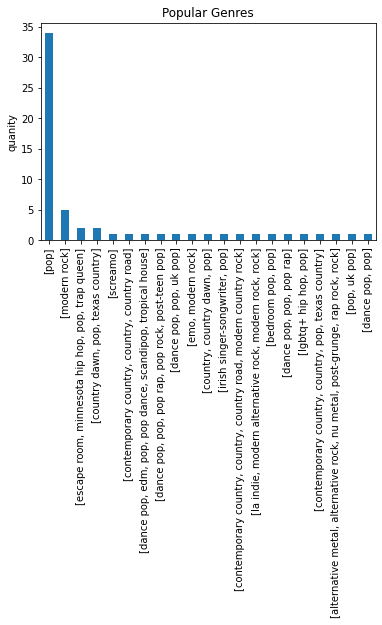

In [8]:
top_songs_df['genres'].value_counts().plot.bar()
plt.title('Popular Genres')
plt.ylabel('quanity')
plt.show()

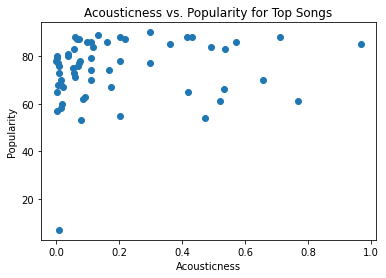

In [9]:
x=np.array(top_songs_df['acousticness'])
y=np.array(top_songs_df['popularity'])
plt.title("Acousticness vs. Popularity for Top Songs")
plt.xlabel("Acousticness")
plt.ylabel("Popularity")
plt.scatter(x, y, cmap='viridis')
plt.show()

In [10]:
sorted_df = df_data.sort_values('popularity', ascending = False).head(60)
sorted_numerical_df = sorted_df[[ "danceability", "energy", "explicit", "mode",
                  "speechiness", "acousticness", "instrumentalness", "liveness",
                  "valence"]]
sorted_df

,id,name,artist_name,artist_id,popularity,type,is_local,explicit,duration_ms,album_name,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature
184,4LRPiXqCikLlN15c3yImP7,As It Was,Harry Styles,6KImCVD70vtIoJWnq6nGn3,93,audio_features,False,False,167303,As It Was,...,0.0557,0.34200,0.001010,0.3110,0.6620,173.930,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,4
935,2QjOHCTQ1Jl3zawyYOpxh6,Sweater Weather,The Neighbourhood,77SW9BnxLY8rJ0RciFqkHh,92,audio_features,False,False,240400,I Love You.,...,0.0336,0.04950,0.017700,0.1010,0.3980,124.053,spotify:track:2QjOHCTQ1Jl3zawyYOpxh6,https://api.spotify.com/v1/tracks/2QjOHCTQ1Jl3...,https://api.spotify.com/v1/audio-analysis/2QjO...,4
141,1qEmFfgcLObUfQm0j1W2CK,Late Night Talking,Harry Styles,6KImCVD70vtIoJWnq6nGn3,90,audio_features,False,False,177955,Harry's House,...,0.0468,0.29800,0.000000,0.1060,0.9010,114.996,spotify:track:1qEmFfgcLObUfQm0j1W2CK,https://api.spotify.com/v1/tracks/1qEmFfgcLObU...,https://api.spotify.com/v1/audio-analysis/1qEm...,4
168,2eAvDnpXP5W0cVtiI0PUxV,Dandelions,Ruth B.,2WzaAvm2bBCf4pEhyuDgCY,89,audio_features,False,False,233720,Safe Haven,...,0.0259,0.01570,0.000000,0.0864,0.4540,116.959,spotify:track:2eAvDnpXP5W0cVtiI0PUxV,https://api.spotify.com/v1/tracks/2eAvDnpXP5W0...,https://api.spotify.com/v1/audio-analysis/2eAv...,3
224,3AJwUDP919kvQ9QcozQPxg,Yellow,Coldplay,4gzpq5DPGxSnKTe4SA8HAU,89,audio_features,False,False,266773,Parachutes,...,0.0281,0.00239,0.000121,0.2340,0.2850,173.372,spotify:track:3AJwUDP919kvQ9QcozQPxg,https://api.spotify.com/v1/tracks/3AJwUDP919kv...,https://api.spotify.com/v1/audio-analysis/3AJw...,4
55,4C6Uex2ILwJi9sZXRdmqXp,Super Freaky Girl,Nicki Minaj,0hCNtLu0JehylgoiP8L4Gh,89,audio_features,False,True,170977,Super Freaky Girl,...,0.2410,0.06450,0.000018,0.3090,0.9120,133.010,spotify:track:4C6Uex2ILwJi9sZXRdmqXp,https://api.spotify.com/v1/tracks/4C6Uex2ILwJi...,https://api.spotify.com/v1/audio-analysis/4C6U...,4
196,5QO79kh1waicV47BqGRL3g,Save Your Tears,The Weeknd,1Xyo4u8uXC1ZmMpatF05PJ,88,audio_features,False,True,215627,After Hours,...,0.0309,0.02120,0.000012,0.5430,0.6440,118.051,spotify:track:5QO79kh1waicV47BqGRL3g,https://api.spotify.com/v1/tracks/5QO79kh1waic...,https://api.spotify.com/v1/audio-analysis/5QO7...,4
606,6UelLqGlWMcVH1E5c4H7lY,Watermelon Sugar,Harry Styles,6KImCVD70vtIoJWnq6nGn3,88,audio_features,False,False,174000,Fine Line,...,0.0465,0.12200,0.000000,0.3350,0.5570,95.390,spotify:track:6UelLqGlWMcVH1E5c4H7lY,https://api.spotify.com/v1/tracks/6UelLqGlWMcV...,https://api.spotify.com/v1/audio-analysis/6Uel...,4
108,0mBP9X2gPCuapvpZ7TGDk3,Left and Right (Feat. Jung Kook of BTS),Charlie Puth,6VuMaDnrHyPL1p4EHjYLi7,88,audio_features,False,False,154487,Left and Right (Feat. Jung Kook of BTS),...,0.0324,0.61900,0.000013,0.0901,0.7190,101.058,spotify:track:0mBP9X2gPCuapvpZ7TGDk3,https://api.spotify.com/v1/tracks/0mBP9X2gPCua...,https://api.spotify.com/v1/audio-analysis/0mBP...,4
114,5O2P9iiztwhomNh8xkR9lJ,Night Changes,One Direction,4AK6F7OLvEQ5QYCBNiQWHq,87,audio_features,False,False,226600,FOUR (Deluxe),...,0.0353,0.85900,0.000000,0.1150,0.3700,120.001,spotify:track:5O2P9iiztwhomNh8xkR9lJ,https://api.spotify.com/v1/tracks/5O2P9iiztwho...,https://api.spotify.com/v1/audio-analysis/5O2P...,4


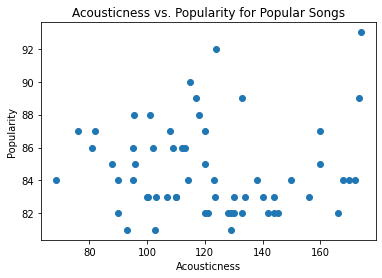

In [11]:
x=np.array(sorted_df['tempo'])
y=np.array(sorted_df['popularity'])
plt.title("Acousticness vs. Popularity for Popular Songs")
plt.xlabel("Acousticness")
plt.ylabel("Popularity")
plt.scatter(x, y, cmap='viridis')
plt.show()

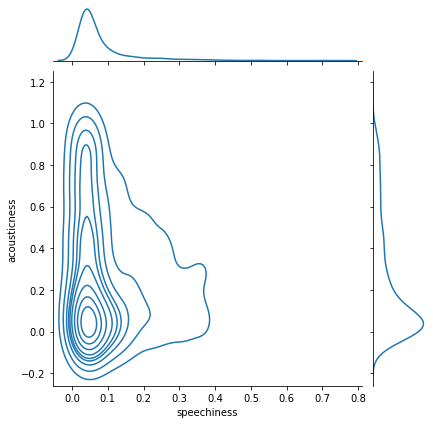

In [12]:
sns.jointplot(x="speechiness", y="acousticness", data=df_data, kind="kde");

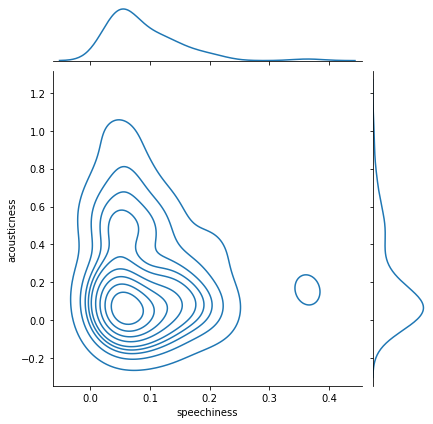

In [13]:
sns.jointplot(x="speechiness", y="acousticness", data=top_songs_df, kind="kde");

In [14]:
#df_data['Year'] = date

In [15]:
#df_pre90 = df_data[df_data.Year <= 1990]
#df_post_90 = df_data[df_data.Year > 1990]

In [16]:
df_data['duration_ms'].value_counts().index.unique()

Int64Index([224867, 221307, 195013, 267653, 186827, 233720, 191600, 210173,
            195760, 225307,
            ...
            163227, 157812, 182680, 120308, 251489, 165907, 220293, 217453,
            170323, 312960],
           dtype='int64', length=960)

In [17]:
print(max(df_data['duration_ms'].value_counts().index.unique()), 
      min(df_data['duration_ms'].value_counts().index.unique()))


442733 64510


In [18]:
def minutes_seconds(x):
    to_seconds = x/1000
    to_minutes = to_seconds/60
    return to_minutes

df_data['duration_minutes'] = df_data['duration_ms'].map(minutes_seconds)
df_data.head()

,id,name,artist_name,artist_id,popularity,type,is_local,explicit,duration_ms,album_name,...,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,duration_minutes
0,1ZcLS62viCBASmHs1ptrlZ,Sweet Jane,Garrett Kato,4S3VOqqGguEZu3vbJMig4t,43,audio_features,False,False,200433,That Low and Lonesome Sound,...,0.582000,0.000010,0.0927,0.190,119.922,spotify:track:1ZcLS62viCBASmHs1ptrlZ,https://api.spotify.com/v1/tracks/1ZcLS62viCBA...,https://api.spotify.com/v1/audio-analysis/1ZcL...,4,3.340550
1,65wICNTM2s1PwXSgKt8f0a,Kill All Your Friends,My Chemical Romance,7FBcuc1gsnv6Y1nwFtNRCb,58,audio_features,False,True,268883,Famous Last Words,...,0.000825,0.000033,0.1210,0.493,102.564,spotify:track:65wICNTM2s1PwXSgKt8f0a,https://api.spotify.com/v1/tracks/65wICNTM2s1P...,https://api.spotify.com/v1/audio-analysis/65wI...,4,4.481383
2,2cViIXIe8Pbd1sOJExMJlK,Cemetery Drive,My Chemical Romance,7FBcuc1gsnv6Y1nwFtNRCb,63,audio_features,False,False,188067,Three Cheers for Sweet Revenge,...,0.000902,0.001720,0.0943,0.655,115.993,spotify:track:2cViIXIe8Pbd1sOJExMJlK,https://api.spotify.com/v1/tracks/2cViIXIe8Pbd...,https://api.spotify.com/v1/audio-analysis/2cVi...,4,3.134450
3,5bTuwAgYUD5MABOIPH8ZMt,You Know What They Do to Guys Like Us in Prison,My Chemical Romance,7FBcuc1gsnv6Y1nwFtNRCb,65,audio_features,False,True,173733,Three Cheers for Sweet Revenge,...,0.003660,0.000000,0.1360,0.674,185.957,spotify:track:5bTuwAgYUD5MABOIPH8ZMt,https://api.spotify.com/v1/tracks/5bTuwAgYUD5M...,https://api.spotify.com/v1/audio-analysis/5bTu...,4,2.895550
4,2M8g01v2vUMn39YQ10l7ef,Fake Your Death,My Chemical Romance,7FBcuc1gsnv6Y1nwFtNRCb,52,audio_features,False,False,200787,May Death Never Stop You,...,0.008800,0.000421,0.2240,0.499,100.137,spotify:track:2M8g01v2vUMn39YQ10l7ef,https://api.spotify.com/v1/tracks/2M8g01v2vUMn...,https://api.spotify.com/v1/audio-analysis/2M8g...,4,3.346450


(array([  3.,  22., 138., 396., 275., 100.,  37.,  17.,   2.,   2.]),
 array([1.07516667, 1.70553833, 2.33591   , 2.96628167, 3.59665333,
        4.227025  , 4.85739667, 5.48776833, 6.11814   , 6.74851167,
        7.37888333]),
 <BarContainer object of 10 artists>)

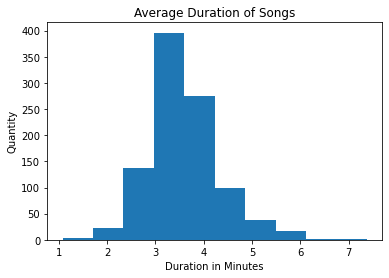

In [19]:
plt.title("Average Duration of Songs")
plt.xlabel("Duration in Minutes")
plt.ylabel("Quantity")
plt.hist(df_data['duration_minutes'])

In [20]:
df_data.duration_minutes.mean()

3.582867489919354

In [21]:
df_data['time_signature'].value_counts().index.unique()

Int64Index([4, 3, 5, 1], dtype='int64')

In [22]:
df_data.columns

Index(['id', 'name', 'artist_name', 'artist_id', 'popularity', 'type',
       'is_local', 'explicit', 'duration_ms', 'album_name', 'album_id',
       'album_type', 'album_release_date', 'album_tracks', 'genres',
       'album_genres', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'uri', 'track_href', 'analysis_url',
       'time_signature', 'duration_minutes'],
      dtype='object')

In [23]:
df_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
popularity,992.0,57.247984,21.226162,0.000000,49.000000,63.000000,72.000000,93.000000
duration_ms,992.0,214972.049395,43971.833929,64510.000000,187196.750000,210253.000000,237276.750000,442733.000000
album_tracks,992.0,11.799395,8.260582,1.000000,6.000000,13.000000,15.000000,59.000000
danceability,992.0,0.604902,0.145378,0.174000,0.514500,0.611500,0.706000,0.950000
energy,992.0,0.651474,0.191793,0.077900,0.521000,0.679000,0.796250,0.993000
key,992.0,5.234879,3.438412,0.000000,2.000000,5.000000,8.000000,11.000000
loudness,992.0,-6.328531,2.502351,-17.203000,-7.581250,-5.798500,-4.554750,-1.299000
mode,992.0,0.681452,0.466148,0.000000,0.000000,1.000000,1.000000,1.000000
speechiness,992.0,0.079702,0.081533,0.023000,0.035100,0.047750,0.084000,0.733000
acousticness,992.0,0.242029,0.274421,0.000014,0.019350,0.115000,0.410500,0.989000


In [24]:
df_data['key'].unique()

array([ 4,  7,  1,  8,  5, 11,  2, 10,  0,  9,  6,  3], dtype=int64)

In [25]:
df_data['artist_name'][:5]

0           Garrett Kato
1    My Chemical Romance
2    My Chemical Romance
3    My Chemical Romance
4    My Chemical Romance
Name: artist_name, dtype: object

In [26]:
df_data['artist_name'].unique()

array(['Garrett Kato', 'My Chemical Romance', 'All Time Low',
       'The Killers', 'Thirty Seconds To Mars', 'Sleeping With Sirens',
       'Conan Gray', 'Ben Rector', 'Bea Miller', 'Bad Suns', 'The Wrecks',
       'Jake Wesley Rogers', 'The Smiths', 'Panic! At The Disco',
       'Sierra Ferrell', 'Meredith Brooks', 'Chloe Adams',
       'Billie Eilish', 'Noah Cyrus', 'Ed Sheeran', 'The Weeknd',
       'Arizona Zervas', 'Easton Corbin', 'White Town', 'Avril Lavigne',
       'Rainbow Kitten Surprise', 'Demi Lovato', 'Nicki Minaj', 'Caamp',
       'Joji', 'Jackson Dean', 'EMMY', 'The Airborne Toxic Event',
       'Taylor Swift', 'Fall Out Boy', 'Jax',
       "Scott Bradlee's Postmodern Jukebox", '88rising', 'Timbaland',
       'Tyler Hubbard', 'The Happy Fits', 'fun.', 'Neon Trees',
       'The Wombats', 'The All-American Rejects', 'Mayday Parade',
       'Yellowcard', 'Twenty One Pilots', 'Classics IV', 'Devon Cole',
       'blackbear', 'Lana Del Rey', 'George Ezra', 'Michael Bublé',
 

In [27]:
len(df_data['name'].unique()) == len(df_data['name'])

#duplicate songs in list that need to be cleaned

False

In [28]:
len(df_data['name'].unique())

965

In [29]:
len(df_data['name'])

992

In [30]:
#out of 995 songs 968 are unique so there are 27 duplicates

In [31]:
df_data.groupby(['name']).size().sort_values(ascending = False)

name
Daylight                                          4
Home                                              3
Sorry                                             2
Drew Barrymore                                    2
Alone                                             2
                                                 ..
Hang 'Em High                                     1
Happier Than Ever                                 1
Hard To Forget                                    1
Harvest Moon - Recorded at Spotify Studios NYC    1
‘tis the damn season                              1
Length: 965, dtype: int64

In [32]:
#songs are same title but different artists. Repeat instances were removed

In [33]:
df_data.sort_values('popularity', ascending = True).head()

,id,name,artist_name,artist_id,popularity,type,is_local,explicit,duration_ms,album_name,...,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,duration_minutes
666,6sq4TaSR25jVNc72iwBcJz,Beacon Hill,Damien Jurado,79JJCxCCfJ8HufX6w8q2k4,0,audio_features,False,False,182560,Saint Bartlett,...,0.9140,0.000391,0.110,0.200,111.334,spotify:track:6sq4TaSR25jVNc72iwBcJz,https://api.spotify.com/v1/tracks/6sq4TaSR25jV...,https://api.spotify.com/v1/audio-analysis/6sq4...,4,3.042667
577,6LyE8gxq8Hq7AGeOvLbGMv,Pirate Flag,Kenny Chesney,3grHWM9bx2E9vwJCdlRv9O,0,audio_features,False,False,225253,Life On A Rock,...,0.0723,0.000009,0.106,0.576,160.128,spotify:track:6LyE8gxq8Hq7AGeOvLbGMv,https://api.spotify.com/v1/tracks/6LyE8gxq8Hq7...,https://api.spotify.com/v1/audio-analysis/6LyE...,4,3.754217
601,0Z0kNthq0sS4lvGz9SSlBF,7 Summers,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,0,audio_features,False,False,210123,7 Summers,...,0.4310,0.000052,0.120,0.588,101.961,spotify:track:0Z0kNthq0sS4lvGz9SSlBF,https://api.spotify.com/v1/tracks/0Z0kNthq0sS4...,https://api.spotify.com/v1/audio-analysis/0Z0k...,4,3.502050
612,7MGRcJy1saXKiphwqJBnRb,Touch It,Ariana Grande,66CXWjxzNUsdJxJ2JdwvnR,0,audio_features,False,False,260000,Dangerous Woman,...,0.0303,0.000000,0.183,0.291,100.906,spotify:track:7MGRcJy1saXKiphwqJBnRb,https://api.spotify.com/v1/tracks/7MGRcJy1saXK...,https://api.spotify.com/v1/audio-analysis/7MGR...,4,4.333333
639,4qPtIDBT2iVQv13tjpXMDt,Make It To Me,Sam Smith,2wY79sveU1sp5g7SokKOiI,0,audio_features,False,False,162732,In The Lonely Hour (Deluxe Edition),...,0.6350,0.000002,0.099,0.222,149.950,spotify:track:4qPtIDBT2iVQv13tjpXMDt,https://api.spotify.com/v1/tracks/4qPtIDBT2iVQ...,https://api.spotify.com/v1/audio-analysis/4qPt...,4,2.712200


In [34]:
df_data['popularity'].unique()

array([43, 58, 63, 65, 52, 67, 57, 76, 75, 70, 54, 60, 64, 61, 69, 72, 77,
       79, 66, 50, 48, 86, 49, 56, 36, 62, 46, 74, 78, 47, 89, 59, 38, 84,
       80, 31, 51, 44, 73, 81, 83, 39, 33, 88, 87, 71, 42,  7, 82, 90, 23,
       15,  1, 29, 68, 37, 53, 93,  6, 41,  0, 32, 25, 55, 85, 40, 45, 28,
        9, 19,  8,  3, 21, 26, 35,  2, 14, 34, 24, 16, 17, 18, 27,  4, 30,
       11, 20, 92, 22], dtype=int64)

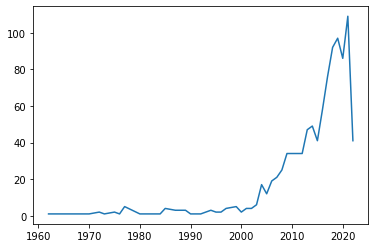

In [35]:
years = df_data['album_release_date'].map(lambda x: x[:4])
df_data['year'] = years.astype(float)
y = df_data.groupby(['year']).count()['id'].values
x = 'years'
plt.plot(df_data.groupby(['year']).count().index, y)

(array([1950., 1960., 1970., 1980., 1990., 2000., 2010., 2020., 2030.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

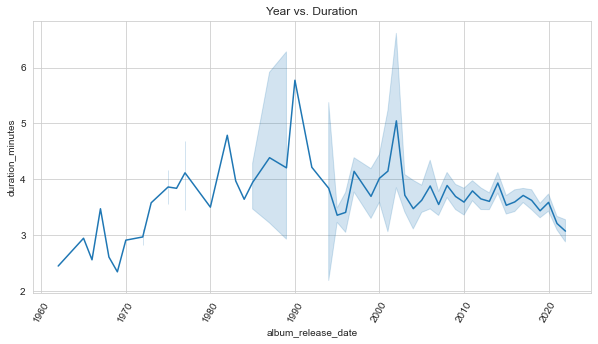

In [36]:
total_dr=df_data.duration_minutes
sns.set_style(style='whitegrid')
fig_dims=(10,5)
years = years.astype(float)
fig, ax = plt.subplots(figsize=fig_dims)
fig=sns.lineplot(x=years.sort_values(), y=total_dr, ax=ax).set(title="Year vs. Duration")
plt.xticks(rotation=60)

In [37]:
#comparing top 10 songs with energy vs their acousticness values
df_data[['artist_name','energy','acousticness']].groupby('artist_name').mean().sort_values(by='energy', ascending=False)[:10]

,energy,acousticness
artist_name,,
Buckcherry,0.978,0.024700
Until I Wake,0.978,0.000286
Sleeping With Sirens,0.975,0.001520
COMETRON,0.972,0.000014
Billy Talent,0.968,0.000391
Fitz and The Tantrums,0.968,0.038700
Pierce The Veil,0.965,0.000038
The Smiths,0.957,0.012000
The Killers,0.956,0.000581


In [38]:
df_data.acousticness.mean()

0.24202885735887103

In [39]:
df_data.energy.mean()

0.6514744959677423

In [40]:
year_avg = df_data[['danceability','energy','liveness','acousticness', 'valence','year']].groupby('year').mean().sort_values(by='year').reset_index()
year_avg.head()

,year,danceability,energy,liveness,acousticness,valence
0,1962.0,0.668,0.260,0.0621,0.4530,0.368
1,1965.0,0.768,0.512,0.0631,0.5700,0.641
2,1966.0,0.653,0.519,0.1010,0.4060,0.822
3,1967.0,0.311,0.325,0.1390,0.0469,0.668
4,1968.0,0.477,0.433,0.1510,0.6890,0.611


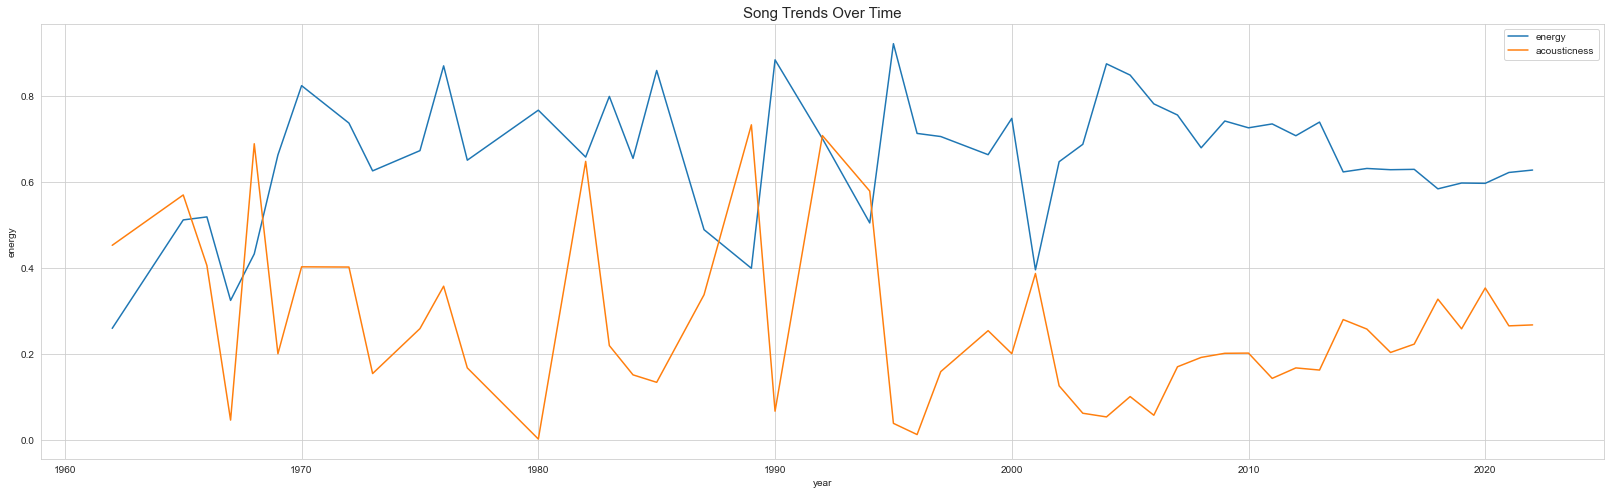

In [41]:
plt.figure(figsize=(28,8))
plt.locator_params(axis="x", nbins=10)
plt.title("Song Trends Over Time", fontsize=15)
lines = ['energy','acousticness']
for line in lines:
    ax = sns.lineplot(x='year', y=line, data=year_avg)
plt.legend(lines)

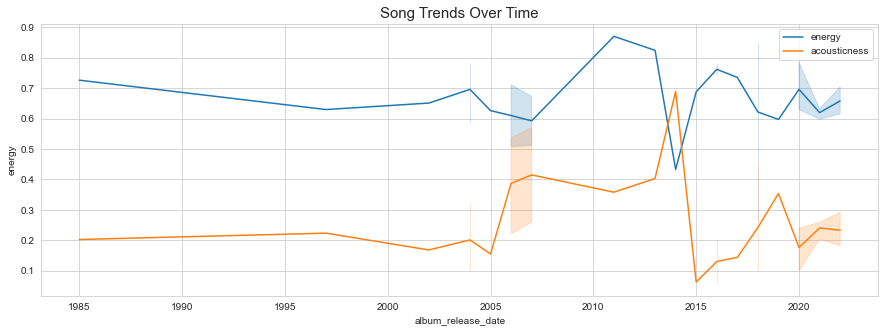

In [42]:
plt.figure(figsize=(15,5))
plt.locator_params(axis="x", nbins=10)
plt.title("Song Trends Over Time", fontsize=15)
lines = ['energy','acousticness']
for line in lines:
    ax = sns.lineplot(x=years.astype(float), y=line, data=year_avg)
plt.legend(lines)

In [43]:
melted = year_avg.melt(id_vars='year')
melted.head()

,year,variable,value
0,1962.0,danceability,0.668
1,1965.0,danceability,0.768
2,1966.0,danceability,0.653
3,1967.0,danceability,0.311
4,1968.0,danceability,0.477


In [44]:
print(len(melted))
print(len(year_avg))

245
49


<AxesSubplot:title={'center':'Song Trends Over Time'}, xlabel='year', ylabel='value'>

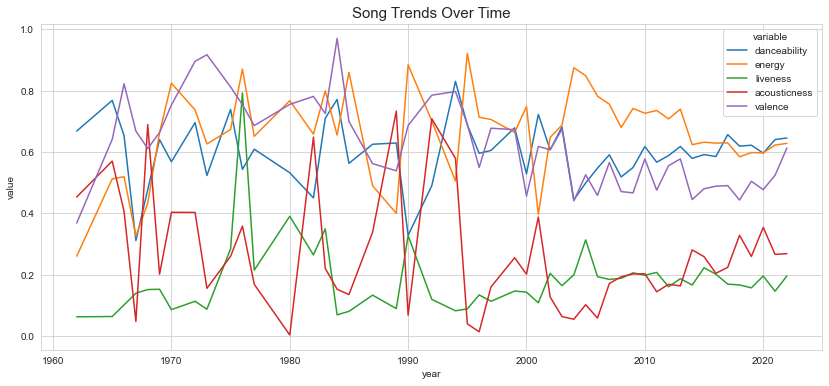

In [45]:
plt.figure(figsize=(14,6))
plt.title("Song Trends Over Time", fontsize=15)
sns.lineplot(x='year', y='value', hue='variable', data=melted)

In [46]:
df_data.artist_name.nunique()

464

In [47]:
df_data.artist_name.value_counts()[:10]

Taylor Swift           79
Panic! At The Disco    51
Ed Sheeran             38
Hozier                 24
My Chemical Romance    22
Mac Miller             18
Doja Cat               16
Demi Lovato            15
Harry Styles           14
Ariana Grande          12
Name: artist_name, dtype: int64

In [48]:
artist_list = df_data.artist_name.value_counts().index[:3]

In [49]:
df_artists = df_data[df_data.artist_name.isin(artist_list)][['year','artist_name',
                                                        'energy']].groupby(['year','artist_name']).count().reset_index()
df_artists.rename(columns={'energy':'song_count'}, inplace=True)
df_artists.head()

,year,artist_name,song_count
0,2005.0,Panic! At The Disco,6
1,2006.0,Taylor Swift,1
2,2008.0,Panic! At The Disco,11
3,2009.0,Panic! At The Disco,1
4,2010.0,Taylor Swift,4


<AxesSubplot:title={'center':'Songs Over Time'}, xlabel='year', ylabel='song_count'>

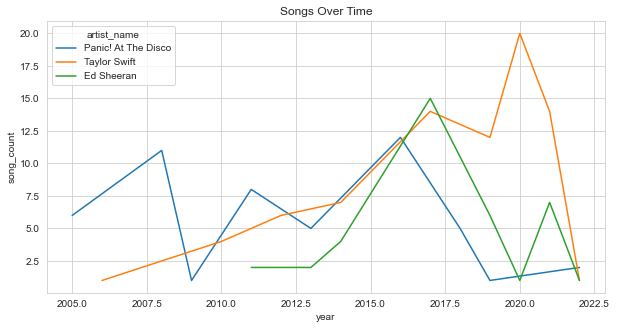

In [50]:
plt.figure(figsize=(10,5))
plt.title("Songs Over Time", fontsize=12)
sns.lineplot(x='year', y='song_count', hue='artist_name', data=df_artists)

In [51]:
df_data.genres.value_counts()[:10]

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[pop]                                            104
[modern rock]                                     53
[dance pop, pop, post-teen pop]                   38
[dance pop, pop]                                  38
[pop, uk pop]                                     38
[irish singer-songwriter, pop]                    24
[emo, pop punk]                                   22
[]                                                20
[hip hop, pittsburgh rap, rap]                    18
[contemporary country, country, country road]     15
Name: genres, dtype: int64

In [52]:
df_genres=df_data.genres.value_counts()[:10]
df_genres

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[pop]                                            104
[modern rock]                                     53
[dance pop, pop, post-teen pop]                   38
[dance pop, pop]                                  38
[pop, uk pop]                                     38
[irish singer-songwriter, pop]                    24
[emo, pop punk]                                   22
[]                                                20
[hip hop, pittsburgh rap, rap]                    18
[contemporary country, country, country road]     15
Name: genres, dtype: int64

In [53]:
df1 = pd.DataFrame(np.zeros((60,3)), columns=artist_list)
df1['year'] = np.arange(1962,2022)
print(df1.shape)
df1.head()

(60, 4)


,Taylor Swift,Panic! At The Disco,Ed Sheeran,year
0,0.0,0.0,0.0,1962
1,0.0,0.0,0.0,1963
2,0.0,0.0,0.0,1964
3,0.0,0.0,0.0,1965
4,0.0,0.0,0.0,1966


In [54]:
df1 = df1.melt(id_vars='year',var_name='artist_name', value_name='song_count')
print(df1.shape)
df1.head()

(180, 3)


,year,artist_name,song_count
0,1962,Taylor Swift,0.0
1,1963,Taylor Swift,0.0
2,1964,Taylor Swift,0.0
3,1965,Taylor Swift,0.0
4,1966,Taylor Swift,0.0


In [55]:
df_merge = pd.merge(df1, df_artists, on=['year', 'artist_name'], how='outer').sort_values(by='year').reset_index(drop=True)

df_merge.head()

,year,artist_name,song_count_x,song_count_y
0,1962.0,Taylor Swift,0.0,NaN
1,1962.0,Panic! At The Disco,0.0,NaN
2,1962.0,Ed Sheeran,0.0,NaN
3,1963.0,Ed Sheeran,0.0,NaN
4,1963.0,Taylor Swift,0.0,NaN


In [56]:
print(df1.dtypes)
print(df_artists.dtypes)

year             int32
artist_name     object
song_count     float64
dtype: object
year           float64
artist_name     object
song_count       int64
dtype: object


In [57]:
#doesnt work
#df_data['dates']=df_data.index.get_level_values('album_release_date')
#df_data.dates=pd.to_datetime(df_data.dates)
#years=df_data.dates.dt.year

<Figure size 1080x1080 with 0 Axes>

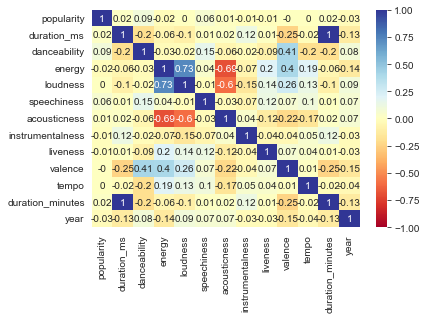

<Figure size 1080x1080 with 0 Axes>

In [58]:
corr_df=df_data.drop(columns={"is_local","explicit","time_signature",
                                "album_tracks","key", "mode"})
matrix = corr_df.corr().round(2)
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='RdYlBu')
plt.figure(figsize = (15,15))

In [59]:
def plot_corr(feature_1,feature_2,title):
    corr_df = df_data[[feature_1,feature_2]]
    corr_df["feature_1_interval"] = pd.cut(df_data[feature_1],np.arange(0,1,0.0001),labels=[f"{feature_1}_{i}" for i in range(1,10000)])
    corr_df = corr_df.groupby("feature_1_interval").median()
    plot = plt.scatter(corr_df,x=feature_1, y=feature_2,trendline="ols",trendline_color_override="red")
    plot.update_traces(marker=dict(size=5,color='rgba(30, 215, 96, .9)',
                                  line=dict(width=1)),
                      selector=dict(mode='markers'))
    plot.update_layout(title_text=title)

    plot.show()

C:\Users\mreed\AppData\Local\Temp/ipykernel_1104/2026443824.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(number_of_rows + 1,number_of_columns,i+1)
C:\Users\mreed\AppData\Local\Temp/ipykernel_1104/2026443824.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(number_of_rows + 1,number_of_columns,i+1)
C:\Users\mreed\AppData\Local\Temp/ipykernel_1104/2026443824.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(number_of_rows + 1,number_of_columns,i+1)
C:\Users\mreed\AppData\Local\Temp/ipykernel_1104/2026443824.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position spec

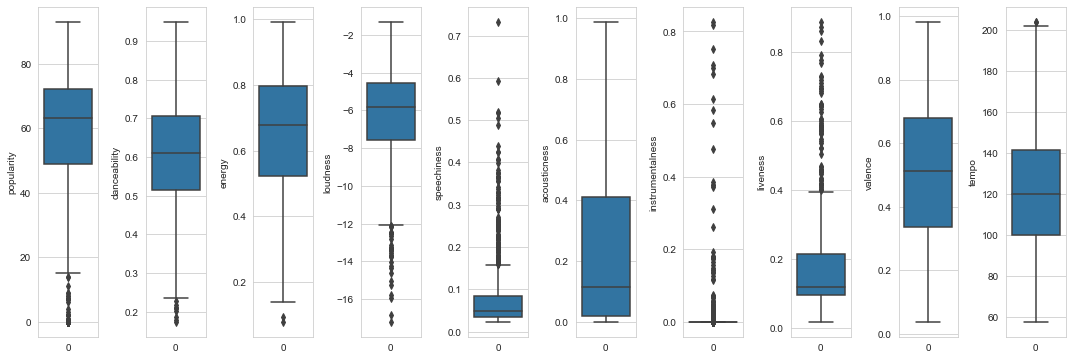

In [60]:
float_df = corr_df[["popularity", "danceability", "energy", "loudness",
                  "speechiness", "acousticness", "instrumentalness", "liveness",
                  "valence", "tempo"]]
float_df = float_df.astype(float)
l = float_df.columns.values
legend=float_df.columns
number_of_columns=10
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(1.5*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    ax = sns.boxplot(data = float_df[l[i]],orient='v')
    ax.set_ylabel(float_df.columns[i])
    plt.tight_layout()

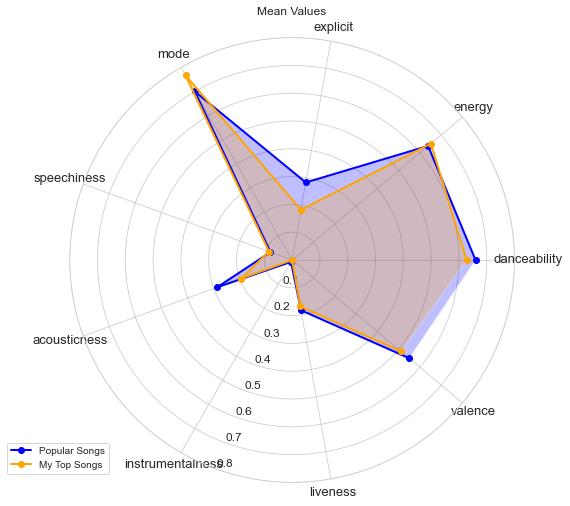

In [61]:
labels = list(sorted_numerical_df)[:]
features = sorted_numerical_df.mean().tolist()
features_all = top_numerical_df.mean().tolist()

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
fig = plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, features, 'o-', linewidth=2, label = "Popular Songs", color= 'blue')
ax.fill(angles, features, alpha=0.25, facecolor='blue')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)


ax.set_rlabel_position(250)
plt.yticks([0.1 , 0.2 , 0.3 , 0.4, 0.5,  0.6, 0.7, 0.8], 
           ["0.1",'0.2', "0.3", "0.4", "0.5", "0.6", '0.7', "0.8"], size=12)
plt.ylim(0,0.8)

ax.plot(angles, features_all, 'o-', linewidth=2, label = "My Top Songs", color= 'orange')
ax.fill(angles, features_all, alpha=0.25, facecolor='orange')
ax.set_title('Mean Values')
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

In [62]:
import re

top_songs_df.artist_name.values[0] = top_songs_df.artist_name.values[0].replace('[', '')
top_songs_df.artist_name.values[0] = top_songs_df.artist_name.values[0].replace(']', '')
top_songs_df.artist_name.values[0]

r1 = re.compile(r"\w{1,20}.\w{1,20}", re.MULTILINE | re.DOTALL)

In [63]:
from collections import Counter

all_artists = []
for i in range(len(top_songs_df.artist_name)):
    r1 = re.compile(r"\w{1,20}.\w{1,20}", re.MULTILINE | re.DOTALL)
    r = r1.findall(top_songs_df.artist_name[i])
    if len(r) > 0:
        all_artists.append(r[0])
list(all_artists)[:15]   

['Taylor Swift',
 'Taylor Swift',
 'Taylor Swift',
 'Conan Gray',
 'Taylor Swift',
 'Lizzo',
 'Taylor Swift',
 'Taylor Swift',
 'Taylor Swift',
 'Panic',
 'Ed Sheeran',
 'Taylor Swift',
 'Taylor Swift',
 'Taylor Swift',
 'Taylor Swift']

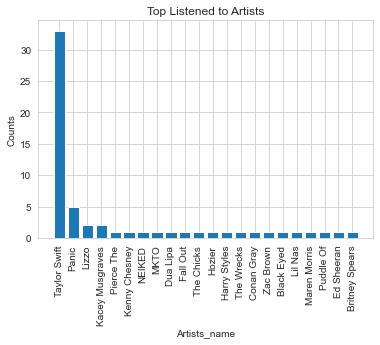

In [64]:
artists = pd.Series(all_artists)
artists = artists.value_counts().rename_axis("artist_names").reset_index(name = "counts")
artists_df = pd.DataFrame(artists)
#print(artists_df)
plt.bar(artists_df["artist_names"], artists_df["counts"])
plt.title('Top Listened to Artists')
plt.xlabel('Artists_name')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.show()

In [65]:
#ML Models

In [69]:
num_df = df_data[["popularity", "danceability", "energy", "key", "loudness", "tempo",
                  "speechiness", "acousticness", "instrumentalness", "liveness",
                  "valence", "duration_minutes", "year"]]
num_df["favorite"] = np.nan

for i in range(len(num_df)):
    if num_df["energy"][i] < .75:
        num_df["favorite"][i] = 1
    else:
        num_df["favorite"][i] = 0

X = num_df.drop(columns = {"favorite", "energy"}, axis="columns")
y = num_df["favorite"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

num_df = num_df.astype(float)

In [67]:
num_df = num_df.sort_values(by=["favorite", 'energy'], ascending=False)
num_df
y.value_counts()

1.0    647
0.0    345
Name: favorite, dtype: int64

In [90]:
#### Linear Regression ####
# this one we cant use the confusion matrix on because it is a regression technique
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)

#accuracy on training set
y_train_pred_reg = reg.predict(X_train)
print('Lin Reg training results:')
train_rmse_reg = np.sqrt(mean_squared_error(y_train, y_train_pred_reg))
train_mae_reg = mean_absolute_error(y_train, y_train_pred_reg)
print('RMSE:', train_rmse_reg, '\nMAE: ', train_mae_reg)

#accuracy on testing set
y_test_pred_reg = reg.predict(X_test)
print('Lin Reg testing results:')
test_rmse_reg = np.sqrt(mean_squared_error(y_test, y_test_pred_reg))
test_mae_reg = mean_absolute_error(y_test, y_test_pred_reg)
print('RMSE:', test_rmse_reg, '\nMAE: ', test_mae_reg)

print('\nslope', reg.coef_, ' intercept', reg.intercept_)

Lin Reg training results:
RMSE: 0.3859551951067489 
MAE:  0.34019130894708294
Lin Reg testing results:
RMSE: 0.38316550624162476 
MAE:  0.3313746754595508

slope [-8.92552847e-04  6.27196154e-01  5.14592171e-03 -6.28346130e-02
 -9.45252132e-05 -8.76452820e-02  2.61078620e-01  2.90462156e-02
 -1.67977465e-01 -5.69364909e-01  1.37684638e-02  6.77592285e-03]  intercept -13.516607954951622


In [72]:
#### XG BOOST ####

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

xgbc = XGBClassifier(n_estimators=100, random_state=1)  # n_estimators is no. of stages, default=100
xgbc.fit(X_train, y_train)


#accuracy on training set
y_train_pred_xgbc = xgbc.predict(X_train)
print('XGBoost training results:')
train_rmse_xgbc = np.sqrt(mean_squared_error(y_train, y_train_pred_xgbc))
train_mae_xgbc = mean_absolute_error(y_train, y_train_pred_xgbc)
print('RMSE:', train_rmse_xgbc, '\nMAE: ', train_mae_xgbc)

#accuracy on testing set
y_test_pred_xgbc = xgbc.predict(X_test)
print('XGBoost testing results:')
test_rmse_xgbc = np.sqrt(mean_squared_error(y_test, y_test_pred_xgbc))
test_mae_xgbc = mean_absolute_error(y_test, y_test_pred_xgbc)
print('RMSE:', test_rmse_xgbc, '\nMAE: ', test_mae_xgbc)

XGBoost training results:
RMSE: 0.0 
MAE:  0.0
XGBoost testing results:
RMSE: 0.4258640645926057 
MAE:  0.181360201511335


In [73]:
#### Random Forest ####

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=1)
rfc.fit(X_train, y_train)


#accuracy on training set
y_train_pred_rfc = rfc.predict(X_train)
print('Random Forest training results:')
train_rmse_rfc = np.sqrt(mean_squared_error(y_train, y_train_pred_rfc))
train_mae_rfc = mean_absolute_error(y_train, y_train_pred_rfc)
print('RMSE:', train_rmse_rfc, '\nMAE: ', train_mae_rfc)

#accuracy on testing set
y_test_pred_rfc = rfc.predict(X_test)
print('Random Forest testing results:')
test_rmse_rfc = np.sqrt(mean_squared_error(y_test, y_test_pred_rfc))
test_mae_rfc = mean_absolute_error(y_test, y_test_pred_rfc)
print('RMSE:', test_rmse_rfc, '\nMAE: ', test_mae_rfc)

Random Forest training results:
RMSE: 0.0 
MAE:  0.0
Random Forest testing results:
RMSE: 0.4432533718284381 
MAE:  0.1964735516372796


In [74]:
#### Gradient Boost ####

from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, random_state=1)
gbc.fit(X_train, y_train)


#accuracy on training set
y_train_pred_gbc = gbc.predict(X_train)
print('Gradient Boost training results:')
train_rmse_gbc = np.sqrt(mean_squared_error(y_train, y_train_pred_gbc))
train_mae_gbc = mean_absolute_error(y_train, y_train_pred_gbc)
print('RMSE:', train_rmse_gbc, '\nMAE: ', train_mae_gbc)

#accuracy on testing set
y_test_pred_gbc = gbc.predict(X_test)
print('Gradient Boost testing results:')
test_rmse_gbc = np.sqrt(mean_squared_error(y_test, y_test_pred_gbc))
test_mae_gbc = mean_absolute_error(y_test, y_test_pred_gbc)
print('RMSE:', test_rmse_gbc, '\nMAE: ', test_mae_gbc)

Gradient Boost training results:
RMSE: 0.10846522890932808 
MAE:  0.011764705882352941
Gradient Boost testing results:
RMSE: 0.43173832918406707 
MAE:  0.18639798488664988


In [75]:
#### KNN ####
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

#accuracy on training set
y_train_pred_knn = knn.predict(X_train)
print('KNN training results:')
train_rmse_knn = np.sqrt(mean_squared_error(y_train, y_train_pred_knn))
train_mae_knn = mean_absolute_error(y_train, y_train_pred_knn)
print('RMSE:', train_rmse_knn, '\nMAE: ', train_mae_knn)

#accuracy on testing set
y_test_pred_knn = knn.predict(X_test)
print('KNN testing results:')
test_rmse_knn = np.sqrt(mean_squared_error(y_test, y_test_pred_knn))
test_mae_knn = mean_absolute_error(y_test, y_test_pred_knn)
print('RMSE:', test_rmse_knn, '\nMAE: ', test_mae_knn)

KNN training results:
RMSE: 0.5169399295433682 
MAE:  0.2672268907563025
KNN testing results:
RMSE: 0.5809746002589922 
MAE:  0.33753148614609574


In [89]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#print('X_train.index:', X_train.index, '\ny_train.index:', y_train.index)
#print('X_test.index:', X_test.index, '\ny_test.index:', y_test.index)

print('\nXGBoost testing results:\n' + 'Accuracy:', metrics.accuracy_score(y_test, y_test_pred_xgbc))
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred_xgbc, labels=[1, 0]), 
                  index=['actual 1', 'actual 0'], 
                  columns=['predicted 1', 'predicted 0'])
print('Confusion matrix:\n', cm)

print('\nRandomForest testing results:\n' + 'Accuracy:', metrics.accuracy_score(y_test, y_test_pred_rfc))
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred_rfc, labels=[1, 0]), 
                  index=['actual 1', 'actual 0'], 
                  columns=['predicted 1', 'predicted 0'])
print('Confusion matrix:\n', cm)

print('\nGradientBoosting testing results:\n' + 'Accuracy:', metrics.accuracy_score(y_test, y_test_pred_gbc))
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred_gbc, labels=[1, 0]), 
                  index=['actual 1', 'actual 0'], 
                  columns=['predicted 1', 'predicted 0'])
print('Confusion matrix:\n', cm)

print('\nKNN testing results:\n' + 'Accuracy:', metrics.accuracy_score(y_test, y_test_pred_knn))
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred_knn, labels=[1, 0]), 
                  index=['actual 1', 'actual 0'], 
                  columns=['predicted 1', 'predicted 0'])
print('Confusion matrix:\n', cm)




XGBoost testing results:
Accuracy: 0.818639798488665
Confusion matrix:
           predicted 1  predicted 0
actual 1          239           27
actual 0           45           86

RandomForest testing results:
Accuracy: 0.8035264483627204
Confusion matrix:
           predicted 1  predicted 0
actual 1          239           27
actual 0           51           80

GradientBoosting testing results:
Accuracy: 0.8136020151133502
Confusion matrix:
           predicted 1  predicted 0
actual 1          239           27
actual 0           47           84

KNN testing results:
Accuracy: 0.6624685138539043
Confusion matrix:
           predicted 1  predicted 0
actual 1          203           63
actual 0           71           60


In [77]:
print('\nLinear Regression testing results:\n' + 'R2 score:', metrics.r2_score(y_test, y_test_pred_reg))



Linear Regression testing results:
R2 score: 0.33594982960527775


In [78]:
playlist_tracks_df = pd.read_csv(r"C:\Users\mreed\OneDrive - Worcester Polytechnic Institute (wpi.edu)\Classes\DS 504\df_tracks_playlist.csv")
playlist_tracks_df

,id,name,artist_name,artist_id,popularity,type,is_local,explicit,duration_ms,album_name,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature
0,6prvUr8l3t7x5GY7heQb5w,Agnes,Glass Animals,4yvcSjfu4PC0CYQyLy4wSq,56,audio_features,False,True,271673,How To Be A Human Being,...,0.0246,0.016200,0.028600,0.1140,0.2330,165.033,spotify:track:6prvUr8l3t7x5GY7heQb5w,https://api.spotify.com/v1/tracks/6prvUr8l3t7x...,https://api.spotify.com/v1/audio-analysis/6prv...,4
1,3NWTRZ0A8xKlBP1qgNftql,Special Affair,The Internet,7GN9PivdemQRKjDt4z5Zv8,61,audio_features,False,True,176187,Ego Death,...,0.0859,0.183000,0.001080,0.1120,0.5180,120.095,spotify:track:3NWTRZ0A8xKlBP1qgNftql,https://api.spotify.com/v1/tracks/3NWTRZ0A8xKl...,https://api.spotify.com/v1/audio-analysis/3NWT...,4
2,1linrfCmITmQHs4enAxTUY,Welcome To The Circus,Five Finger Death Punch,5t28BP42x2axFnqOOMg3CM,66,audio_features,False,True,256742,AfterLife,...,0.0806,0.000076,0.000000,0.7880,0.2970,139.982,spotify:track:1linrfCmITmQHs4enAxTUY,https://api.spotify.com/v1/tracks/1linrfCmITmQ...,https://api.spotify.com/v1/audio-analysis/1lin...,4
3,300DUx4tdtCdGEUXR032jA,"Palace/Curse (feat. Tyler, The Creator & Steve...",The Internet,7GN9PivdemQRKjDt4z5Zv8,67,audio_features,False,True,440013,Ego Death,...,0.3230,0.035100,0.000727,0.2430,0.2610,67.104,spotify:track:300DUx4tdtCdGEUXR032jA,https://api.spotify.com/v1/tracks/300DUx4tdtCd...,https://api.spotify.com/v1/audio-analysis/300D...,4
4,4LlLWDyDTPBLASLX0BEDlX,Untamed,Grand Magus,7GTkjp7qsfmx8iJzBUQLmN,14,audio_features,False,False,225940,Wolf God,...,0.0757,0.000274,0.190000,0.1180,0.2670,94.350,spotify:track:4LlLWDyDTPBLASLX0BEDlX,https://api.spotify.com/v1/tracks/4LlLWDyDTPBL...,https://api.spotify.com/v1/audio-analysis/4LlL...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,58zsLZPvfflaiIbNWoA22O,Human,Rag'n'Bone Man,4f9iBmdUOhQWeP7dcAn1pf,78,audio_features,False,False,200187,Human (Deluxe),...,0.3020,0.393000,0.000000,0.1650,0.5540,75.087,spotify:track:58zsLZPvfflaiIbNWoA22O,https://api.spotify.com/v1/tracks/58zsLZPvffla...,https://api.spotify.com/v1/audio-analysis/58zs...,4
247,2IO7yf562c1zLzpanal1DT,Gasoline,Halsey,26VFTg2z8YR0cCuwLzESi2,71,audio_features,False,True,199593,BADLANDS (Deluxe),...,0.0399,0.223000,0.000000,0.1290,0.3190,119.997,spotify:track:2IO7yf562c1zLzpanal1DT,https://api.spotify.com/v1/tracks/2IO7yf562c1z...,https://api.spotify.com/v1/audio-analysis/2IO7...,4
248,64GRDrL1efgXclrhVCeuA0,Lay Me Down,Sam Smith,2wY79sveU1sp5g7SokKOiI,73,audio_features,False,False,219536,In The Lonely Hour (Drowning Shadows Edition),...,0.0373,0.919000,0.000000,0.1070,0.3260,125.319,spotify:track:64GRDrL1efgXclrhVCeuA0,https://api.spotify.com/v1/tracks/64GRDrL1efgX...,https://api.spotify.com/v1/audio-analysis/64GR...,4
249,550rQQCGkrTzvp4SfpOPzx,Hallelujah,Pentatonix,26AHtbjWKiwYzsoGoUZq53,65,audio_features,False,False,268960,A Pentatonix Christmas,...,0.0356,0.454000,0.000000,0.3380,0.3660,118.669,spotify:track:550rQQCGkrTzvp4SfpOPzx,https://api.spotify.com/v1/tracks/550rQQCGkrTz...,https://api.spotify.com/v1/audio-analysis/550r...,4


In [79]:
#recommendation_tracks = get_recommendations(sp, playlist_tracks_df["id"])
#recommendation_tracks = df_edit(recommendation_tracks)
#recommendation_tracks = get_genre(recommendation_tracks)

In [80]:
playlist_tracks_df

,id,name,artist_name,artist_id,popularity,type,is_local,explicit,duration_ms,album_name,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature
0,6prvUr8l3t7x5GY7heQb5w,Agnes,Glass Animals,4yvcSjfu4PC0CYQyLy4wSq,56,audio_features,False,True,271673,How To Be A Human Being,...,0.0246,0.016200,0.028600,0.1140,0.2330,165.033,spotify:track:6prvUr8l3t7x5GY7heQb5w,https://api.spotify.com/v1/tracks/6prvUr8l3t7x...,https://api.spotify.com/v1/audio-analysis/6prv...,4
1,3NWTRZ0A8xKlBP1qgNftql,Special Affair,The Internet,7GN9PivdemQRKjDt4z5Zv8,61,audio_features,False,True,176187,Ego Death,...,0.0859,0.183000,0.001080,0.1120,0.5180,120.095,spotify:track:3NWTRZ0A8xKlBP1qgNftql,https://api.spotify.com/v1/tracks/3NWTRZ0A8xKl...,https://api.spotify.com/v1/audio-analysis/3NWT...,4
2,1linrfCmITmQHs4enAxTUY,Welcome To The Circus,Five Finger Death Punch,5t28BP42x2axFnqOOMg3CM,66,audio_features,False,True,256742,AfterLife,...,0.0806,0.000076,0.000000,0.7880,0.2970,139.982,spotify:track:1linrfCmITmQHs4enAxTUY,https://api.spotify.com/v1/tracks/1linrfCmITmQ...,https://api.spotify.com/v1/audio-analysis/1lin...,4
3,300DUx4tdtCdGEUXR032jA,"Palace/Curse (feat. Tyler, The Creator & Steve...",The Internet,7GN9PivdemQRKjDt4z5Zv8,67,audio_features,False,True,440013,Ego Death,...,0.3230,0.035100,0.000727,0.2430,0.2610,67.104,spotify:track:300DUx4tdtCdGEUXR032jA,https://api.spotify.com/v1/tracks/300DUx4tdtCd...,https://api.spotify.com/v1/audio-analysis/300D...,4
4,4LlLWDyDTPBLASLX0BEDlX,Untamed,Grand Magus,7GTkjp7qsfmx8iJzBUQLmN,14,audio_features,False,False,225940,Wolf God,...,0.0757,0.000274,0.190000,0.1180,0.2670,94.350,spotify:track:4LlLWDyDTPBLASLX0BEDlX,https://api.spotify.com/v1/tracks/4LlLWDyDTPBL...,https://api.spotify.com/v1/audio-analysis/4LlL...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,58zsLZPvfflaiIbNWoA22O,Human,Rag'n'Bone Man,4f9iBmdUOhQWeP7dcAn1pf,78,audio_features,False,False,200187,Human (Deluxe),...,0.3020,0.393000,0.000000,0.1650,0.5540,75.087,spotify:track:58zsLZPvfflaiIbNWoA22O,https://api.spotify.com/v1/tracks/58zsLZPvffla...,https://api.spotify.com/v1/audio-analysis/58zs...,4
247,2IO7yf562c1zLzpanal1DT,Gasoline,Halsey,26VFTg2z8YR0cCuwLzESi2,71,audio_features,False,True,199593,BADLANDS (Deluxe),...,0.0399,0.223000,0.000000,0.1290,0.3190,119.997,spotify:track:2IO7yf562c1zLzpanal1DT,https://api.spotify.com/v1/tracks/2IO7yf562c1z...,https://api.spotify.com/v1/audio-analysis/2IO7...,4
248,64GRDrL1efgXclrhVCeuA0,Lay Me Down,Sam Smith,2wY79sveU1sp5g7SokKOiI,73,audio_features,False,False,219536,In The Lonely Hour (Drowning Shadows Edition),...,0.0373,0.919000,0.000000,0.1070,0.3260,125.319,spotify:track:64GRDrL1efgXclrhVCeuA0,https://api.spotify.com/v1/tracks/64GRDrL1efgX...,https://api.spotify.com/v1/audio-analysis/64GR...,4
249,550rQQCGkrTzvp4SfpOPzx,Hallelujah,Pentatonix,26AHtbjWKiwYzsoGoUZq53,65,audio_features,False,False,268960,A Pentatonix Christmas,...,0.0356,0.454000,0.000000,0.3380,0.3660,118.669,spotify:track:550rQQCGkrTzvp4SfpOPzx,https://api.spotify.com/v1/tracks/550rQQCGkrTz...,https://api.spotify.com/v1/audio-analysis/550r...,4


In [81]:
alex_df = playlist_tracks_df.sort_values('popularity', ascending = False).head(20)
num_alex_df = alex_df[[ "danceability", "energy", "explicit", "mode",
                  "speechiness", "acousticness", "instrumentalness", "liveness",
                  "valence"]]
alex_df

,id,name,artist_name,artist_id,popularity,type,is_local,explicit,duration_ms,album_name,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature
17,4h9wh7iOZ0GGn8QVp4RAOB,I Ain't Worried,OneRepublic,5Pwc4xIPtQLFEnJriah9YJ,95,audio_features,False,False,148486,I Ainâ€™t Worried (Music From The Motion Pictu...,...,0.0475,0.082600,0.000745,0.0546,0.825,139.994,spotify:track:4h9wh7iOZ0GGn8QVp4RAOB,https://api.spotify.com/v1/tracks/4h9wh7iOZ0GG...,https://api.spotify.com/v1/audio-analysis/4h9w...,4
9,6xGruZOHLs39ZbVccQTuPZ,Glimpse of Us,Joji,3MZsBdqDrRTJihTHQrO6Dq,92,audio_features,False,False,233456,Glimpse of Us,...,0.0531,0.891000,0.000005,0.1410,0.268,169.914,spotify:track:6xGruZOHLs39ZbVccQTuPZ,https://api.spotify.com/v1/tracks/6xGruZOHLs39...,https://api.spotify.com/v1/audio-analysis/6xGr...,3
79,02MWAaffLxlfxAUY7c5dvx,Heat Waves,Glass Animals,4yvcSjfu4PC0CYQyLy4wSq,87,audio_features,False,False,238805,Dreamland (+ Bonus Levels),...,0.0944,0.440000,0.000007,0.0921,0.531,80.870,spotify:track:02MWAaffLxlfxAUY7c5dvx,https://api.spotify.com/v1/tracks/02MWAaffLxlf...,https://api.spotify.com/v1/audio-analysis/02MW...,4
173,7qEHsqek33rTcFNT9PFqLf,Someone You Loved,Lewis Capaldi,4GNC7GD6oZMSxPGyXy4MNB,86,audio_features,False,False,182161,Divinely Uninspired To A Hellish Extent,...,0.0319,0.751000,0.000000,0.1050,0.446,109.891,spotify:track:7qEHsqek33rTcFNT9PFqLf,https://api.spotify.com/v1/tracks/7qEHsqek33rT...,https://api.spotify.com/v1/audio-analysis/7qEH...,4
157,5PjdY0CKGZdEuoNab3yDmX,STAY (with Justin Bieber),The Kid LAROI,2tIP7SsRs7vjIcLrU85W8J,85,audio_features,False,True,141806,F*CK LOVE 3: OVER YOU,...,0.0483,0.038300,0.000000,0.1030,0.478,169.928,spotify:track:5PjdY0CKGZdEuoNab3yDmX,https://api.spotify.com/v1/tracks/5PjdY0CKGZdE...,https://api.spotify.com/v1/audio-analysis/5Pjd...,4
58,2DlHlPMa4M17kufBvI2lEN,Chop Suey!,System Of A Down,5eAWCfyUhZtHHtBdNk56l1,82,audio_features,False,False,210240,Toxicity,...,0.1190,0.000278,0.001500,0.1320,0.287,127.066,spotify:track:2DlHlPMa4M17kufBvI2lEN,https://api.spotify.com/v1/tracks/2DlHlPMa4M17...,https://api.spotify.com/v1/audio-analysis/2DlH...,4
135,0I3q5fE6wg7LIfHGngUTnV,Ms. Jackson,Outkast,1G9G7WwrXka3Z1r7aIDjI7,81,audio_features,False,True,270507,Stankonia,...,0.2690,0.143000,0.000000,0.0771,0.613,94.948,spotify:track:0I3q5fE6wg7LIfHGngUTnV,https://api.spotify.com/v1/tracks/0I3q5fE6wg7L...,https://api.spotify.com/v1/audio-analysis/0I3q...,4
142,5rb9QrpfcKFHM1EUbSIurX,Yeah! (feat. Lil Jon & Ludacris),Usher,23zg3TcAtWQy7J6upgbUnj,81,audio_features,False,False,250373,Confessions (Expanded Edition),...,0.1120,0.018300,0.000000,0.0388,0.583,105.018,spotify:track:5rb9QrpfcKFHM1EUbSIurX,https://api.spotify.com/v1/tracks/5rb9QrpfcKFH...,https://api.spotify.com/v1/audio-analysis/5rb9...,4
148,7vGuf3Y35N4wmASOKLUVVU,Silence,Marshmello,64KEffDW9EtZ1y2vBYgq8T,80,audio_features,False,False,180823,Silence,...,0.0853,0.256000,0.000005,0.1700,0.286,141.971,spotify:track:7vGuf3Y35N4wmASOKLUVVU,https://api.spotify.com/v1/tracks/7vGuf3Y35N4w...,https://api.spotify.com/v1/audio-analysis/7vGu...,4
60,0snQkGI5qnAmohLE7jTsTn,Toxicity,System Of A Down,5eAWCfyUhZtHHtBdNk56l1,80,audio_features,False,False,218933,Toxicity,...,0.0536,0.000264,0.002490,0.2040,0.480,116.680,spotify:track:0snQkGI5qnAmohLE7jTsTn,https://api.spotify.com/v1/tracks/0snQkGI5qnAm...,https://api.spotify.com/v1/audio-analysis/0snQ...,3


In [82]:
def minutes_seconds(x):
    to_seconds = x/1000
    to_minutes = to_seconds/60
    return to_minutes

playlist_tracks_df['duration_minutes'] = playlist_tracks_df['duration_ms'].map(minutes_seconds)
playlist_tracks_df.head()

,id,name,artist_name,artist_id,popularity,type,is_local,explicit,duration_ms,album_name,...,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,duration_minutes
0,6prvUr8l3t7x5GY7heQb5w,Agnes,Glass Animals,4yvcSjfu4PC0CYQyLy4wSq,56,audio_features,False,True,271673,How To Be A Human Being,...,0.016200,0.028600,0.114,0.233,165.033,spotify:track:6prvUr8l3t7x5GY7heQb5w,https://api.spotify.com/v1/tracks/6prvUr8l3t7x...,https://api.spotify.com/v1/audio-analysis/6prv...,4,4.527883
1,3NWTRZ0A8xKlBP1qgNftql,Special Affair,The Internet,7GN9PivdemQRKjDt4z5Zv8,61,audio_features,False,True,176187,Ego Death,...,0.183000,0.001080,0.112,0.518,120.095,spotify:track:3NWTRZ0A8xKlBP1qgNftql,https://api.spotify.com/v1/tracks/3NWTRZ0A8xKl...,https://api.spotify.com/v1/audio-analysis/3NWT...,4,2.936450
2,1linrfCmITmQHs4enAxTUY,Welcome To The Circus,Five Finger Death Punch,5t28BP42x2axFnqOOMg3CM,66,audio_features,False,True,256742,AfterLife,...,0.000076,0.000000,0.788,0.297,139.982,spotify:track:1linrfCmITmQHs4enAxTUY,https://api.spotify.com/v1/tracks/1linrfCmITmQ...,https://api.spotify.com/v1/audio-analysis/1lin...,4,4.279033
3,300DUx4tdtCdGEUXR032jA,"Palace/Curse (feat. Tyler, The Creator & Steve...",The Internet,7GN9PivdemQRKjDt4z5Zv8,67,audio_features,False,True,440013,Ego Death,...,0.035100,0.000727,0.243,0.261,67.104,spotify:track:300DUx4tdtCdGEUXR032jA,https://api.spotify.com/v1/tracks/300DUx4tdtCd...,https://api.spotify.com/v1/audio-analysis/300D...,4,7.333550
4,4LlLWDyDTPBLASLX0BEDlX,Untamed,Grand Magus,7GTkjp7qsfmx8iJzBUQLmN,14,audio_features,False,False,225940,Wolf God,...,0.000274,0.190000,0.118,0.267,94.350,spotify:track:4LlLWDyDTPBLASLX0BEDlX,https://api.spotify.com/v1/tracks/4LlLWDyDTPBL...,https://api.spotify.com/v1/audio-analysis/4LlL...,4,3.765667


(array([  4.,  10.,  71., 104.,  38.,  11.,   5.,   5.,   2.,   1.]),
 array([0.82021667, 1.63541667, 2.45061667, 3.26581667, 4.08101667,
        4.89621667, 5.71141667, 6.52661667, 7.34181667, 8.15701667,
        8.97221667]),
 <BarContainer object of 10 artists>)

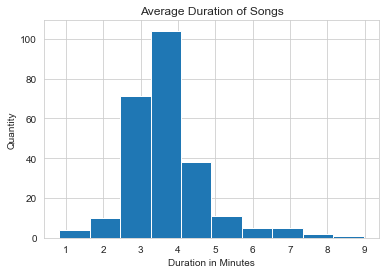

In [83]:
plt.title("Average Duration of Songs")
plt.xlabel("Duration in Minutes")
plt.ylabel("Quantity")
plt.hist(playlist_tracks_df['duration_minutes'])

In [84]:
playlist_tracks_df.duration_minutes.mean()

3.711917729083667

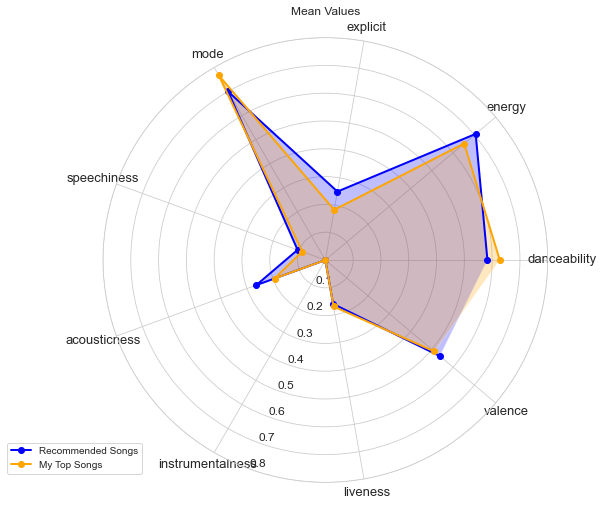

In [85]:
labels = list(num_alex_df)[:]
features = num_alex_df.mean().tolist()
features_all = top_numerical_df.mean().tolist()

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
fig = plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, features, 'o-', linewidth=2, label = "Recommended Songs", color= 'blue')
ax.fill(angles, features, alpha=0.25, facecolor='blue')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)


ax.set_rlabel_position(250)
plt.yticks([0.1 , 0.2 , 0.3 , 0.4, 0.5,  0.6, 0.7, 0.8], 
           ["0.1",'0.2', "0.3", "0.4", "0.5", "0.6", '0.7', "0.8"], size=12)
plt.ylim(0,0.8)

ax.plot(angles, features_all, 'o-', linewidth=2, label = "My Top Songs", color= 'orange')
ax.fill(angles, features_all, alpha=0.25, facecolor='orange')
ax.set_title('Mean Values')
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

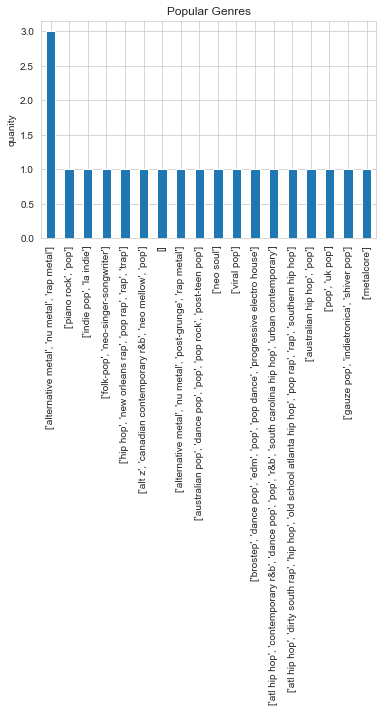

In [86]:
alex_df['genres'].value_counts().plot.bar()
plt.title('Popular Genres')
plt.ylabel('quanity')
plt.show()

In [87]:
# Training data
X = playlist_tracks_df[['popularity', 'explicit', 'duration_ms', 'danceability', 'energy',
                        'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                        'liveness', 'valence', 'tempo', 'time_signature', 'genres']]  # order here is important for xgboost later
y = playlist_tracks_df['ratings']

# Drop NA
X = X.dropna()
recommendation_tracks_df = recommendation_tracks_df.dropna()

# Create genre columns (one-hot encoding)
X = X.drop('genres', 1).join(X['genres'].str.join('|').str.get_dummies())
X_recommend = recommendation_tracks.copy()
X_recommend = X_recommend.drop('genres', 1).join(X_recommend['genres'].str.join('|').str.get_dummies())

# Ensure features are consistent across training, test, and evaluation
X = X[X.columns.intersection(X_recommend.columns)]
X_recommend = X_recommend[X_recommend.columns.intersection(X.columns)]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

KeyError: 'ratings'